In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def get_data(stocks,start,end):
    stockdata= yf.download(stocks, start=start, end=end)['Adj Close']
    returns= stockdata.pct_change()
    meanreturns= returns.mean()
    covmetrix= returns.cov()

    return meanreturns,covmetrix


stockslist=['KFINTECH','POONAWALLA','IRCTC','AWL','INFY','WIPRO','NEOGEN','SUDARSCHEM','KPITTECH','NEWGEN','GOCOLORS','VEDL','DIXON','CHOLAHLDNG','DBL','ENGINERSIN','DOLATALGO','EDELWEISS','SOUTHBANK','EXIDEIND','MASFIN']

stocks = [stock + '.BO' for stock in stockslist ]

enddate = dt.datetime.now()

startdate= enddate - dt.timedelta(days=300)

meanreturns, covmetrix= get_data(stocks,startdate,enddate)

print(meanreturns)

[*********************100%%**********************]  21 of 21 completed

Ticker
AWL.BO           0.000886
CHOLAHLDNG.BO    0.001800
DBL.BO           0.003150
DIXON.BO         0.004184
DOLATALGO.BO     0.005557
EDELWEISS.BO     0.001396
ENGINERSIN.BO    0.003146
EXIDEIND.BO      0.003480
GOCOLORS.BO     -0.000576
INFY.BO          0.001329
IRCTC.BO         0.001677
KFINTECH.BO      0.004773
KPITTECH.BO      0.002090
MASFIN.BO       -0.000159
NEOGEN.BO        0.000108
NEWGEN.BO        0.004503
POONAWALLA.BO    0.000105
SOUTHBANK.BO     0.000114
SUDARSCHEM.BO    0.003791
VEDL.BO          0.004039
WIPRO.BO         0.001083
dtype: float64



/var/folders/c9/8t42c60d22d2m1m_z6lc5_z00000gn/T/ipykernel_1675/2876100707.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns= stockdata.pct_change()


In [2]:
weights= np.random.random(len(meanreturns))
weights /= np.sum(weights)

weights

array([0.04020517, 0.01452859, 0.00685632, 0.06266337, 0.01050471,
       0.05233179, 0.02609294, 0.0189384 , 0.08988851, 0.07078654,
       0.09452031, 0.00807427, 0.07327365, 0.05210869, 0.05724295,
       0.07374207, 0.07467649, 0.09367353, 0.02231586, 0.01973714,
       0.03783869])

now we will define monte carlo simulations and the time frame

108625.50853319901
106693.20819078648


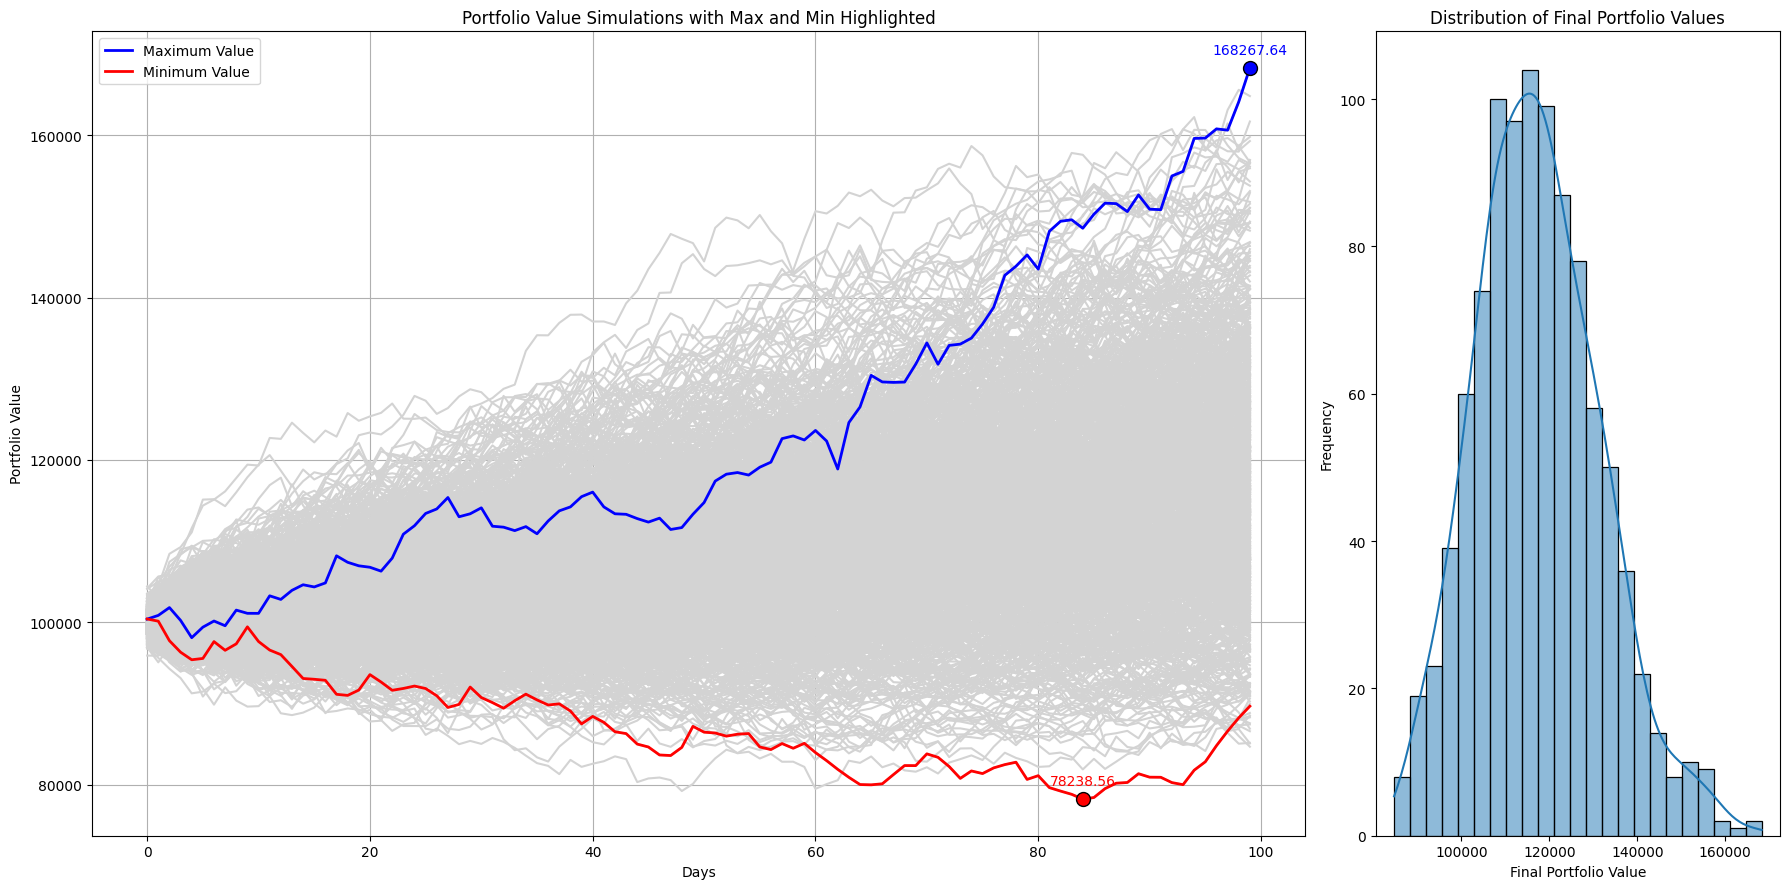

In [14]:
import seaborn as sns 

mc_sims= 1000
T=100 #timeframe in days

meanM= np.full(shape=(T,len(weights)),fill_value=meanreturns)

meanM= meanM.T

portfolio_sims = np.full(shape=(T,mc_sims),fill_value=0.0)

initial_port=  100000
for m in range(0,mc_sims):
    Z= np.random.normal(size=(T,len(weights)))
    L=np.linalg.cholesky(covmetrix)
    dailyreturns= meanM + np.inner(L,Z)

    portfolio_sims[:,m] = np.cumprod(np.inner(weights,dailyreturns.T)+1) * initial_port

print(np.mean(portfolio_sims))
print(np.median(portfolio_sims))

max_value = np.max(portfolio_sims)
min_value = np.min(portfolio_sims)
max_idx = np.unravel_index(np.argmax(portfolio_sims), portfolio_sims.shape)
min_idx = np.unravel_index(np.argmin(portfolio_sims), portfolio_sims.shape)

# Create figure and gridspec for layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# Plot portfolio value simulations
ax0 = plt.subplot(gs[0])
ax0.plot(portfolio_sims, color='lightgray')  # Plot all simulations
ax0.plot(portfolio_sims[:, max_idx[1]], color='blue', label='Maximum Value', linewidth=2)
ax0.plot(portfolio_sims[:, min_idx[1]], color='red', label='Minimum Value', linewidth=2)

# Highlight max and min points
ax0.scatter(max_idx[0], max_value, color='blue', s=100, edgecolor='black', zorder=5)
ax0.scatter(min_idx[0], min_value, color='red', s=100, edgecolor='black', zorder=5)

# Annotate max and min points
ax0.annotate(f'{max_value:.2f}', (max_idx[0], max_value), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
ax0.annotate(f'{min_value:.2f}', (min_idx[0], min_value), textcoords="offset points", xytext=(0,10), ha='center', color='red')

ax0.set_ylabel('Portfolio Value')
ax0.set_xlabel('Days')
ax0.set_title('Portfolio Value Simulations with Max and Min Highlighted')
ax0.legend()
ax0.grid(True)

# Plot distribution of final portfolio values
final_values = portfolio_sims[-1, :]
ax1 = plt.subplot(gs[1])
sns.histplot(final_values, kde=True, ax=ax1)
ax1.set_title('Distribution of Final Portfolio Values')
ax1.set_xlabel('Final Portfolio Value')
ax1.set_ylabel('Frequency')

plt.tight_layout()
plt.show()